# Download Data

- Download data to the local environment
- Unzip data to `./Dataset/Images/` and `./Dataset/Masks/` directory

In [ ]:
from IPython.display import clear_output
!gdown --folder 1JMt7qdKcukjz4yvo58VVFeybizpmxRqo
!7z x -tzip -o./Dataset/ ./Dataset/Masks.zip
!7z x -tzip -o./Dataset/ ./Dataset/Images.zip
clear_output()

# Imports

In [ ]:
!pip install torchmetrics
clear_output()

In [ ]:
from IPython.display import clear_output
from glob import glob
import os
from os import path
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Progbar
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
# Model
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights, lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utility Functions

In [ ]:
def show(a, b):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(a.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(b.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

# Dataset

In [ ]:
class FlameSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform=None, mask_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.filenames = self.get_filenames()

    def remove_ext(self, filenames):
        return [f.split(".")[0] for f in filenames]

    def get_filenames(self):
        images = self.remove_ext(os.listdir(self.image_dir))
        masks = self.remove_ext(os.listdir(self.mask_dir))

        if set(images) != set(masks):
            raise Exception("Filename mismatch in Images and Masks")

        return images

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            raise Exception("Slice passed instead of an index")
        
        filename = self.filenames[idx]
        image_path = path.join(self.image_dir, filename)
        mask_path = path.join(self.mask_dir, filename)

        image = read_image(image_path + ".jpg", ImageReadMode.RGB).type(torch.float).to(device)
        mask = read_image(mask_path + ".png", ImageReadMode.GRAY).type(torch.float).to(device)

        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

## Visualizing Data

In [ ]:
IMAGE_DIR = "./Dataset/Images"
MASK_DIR = "./Dataset/Masks"

dataset = FlameSegDataset(IMAGE_DIR, MASK_DIR)

FLAME Segmentation Dataset has 2003 instances.

In [ ]:
len(dataset)

2003

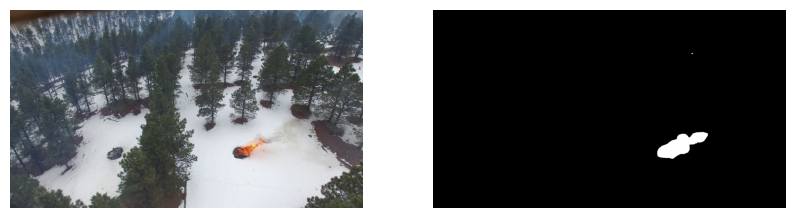

In [ ]:
img, mask = dataset[0]
show(img, mask)

## Data Transforms

- see `DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()`

```
SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
```

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(520, antialias=True),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

preprocess_mask = transforms.Compose([
    transforms.Resize(520, antialias=True)
])

In [ ]:
dataset = FlameSegDataset(IMAGE_DIR, MASK_DIR, img_transform=preprocess, mask_transform=preprocess_mask)

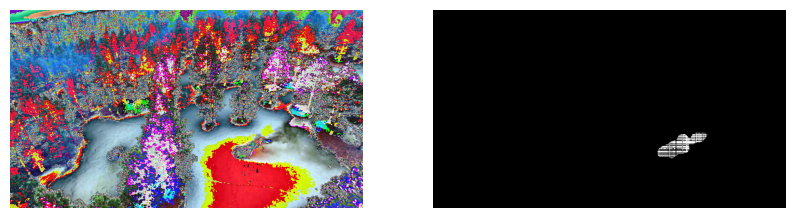

In [ ]:
img, mask = dataset[0]
show(img, mask)

# Dataloader

In [ ]:
BATCH_SIZE = 8
TRAIN_FRAC = 0.8

train, test = random_split(dataset, [TRAIN_FRAC, 1-TRAIN_FRAC], torch.Generator().manual_seed(10))

train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print("Train Size:", len(train))
print("Test Size:", len(test))

Train Size: 1603
Test Size: 400


# deeplabv3_resnet50

In [ ]:
class deeplabv3_resnet50_FLAME(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

        for param in self.model.parameters():
            param.requires_grad = False
          
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        out = self.model(x)["out"]
        return torch.round(torch.sigmoid(out))

In [ ]:
model1 = deeplabv3_resnet50_FLAME().to(device)

In [ ]:
PATH = "./drive/MyDrive/Checkpoints/deeplabv3_resnet50_FLAME.pt"

checkpoint = torch.load(PATH)
model1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

# lraspp_mobilenet_v3_large

In [ ]:
class lraspp_mobilenet_v3_large_FLAME(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = lraspp_mobilenet_v3_large(weights=LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)

        for param in self.model.parameters():
            param.requires_grad = False
          
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.model.classifier.low_classifier = nn.Conv2d(40, 1, kernel_size=(1, 1), stride=(1, 1))
        self.model.classifier.high_classifier = nn.Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        out = self.model(x)["out"]
        return torch.round(torch.sigmoid(out))

In [ ]:
model2 = lraspp_mobilenet_v3_large_FLAME().to(device)

In [ ]:
PATH = "./drive/MyDrive/Checkpoints/lraspp_mobilenet_v3_large_FLAME.pt"

checkpoint = torch.load(PATH)
model2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
for param in model2.parameters():
    param.requires_grad = False

# Ensemble Model

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1.model.backbone
        self.model2 = model2.model.backbone
        self.conv1 = nn.Conv2d(in_channels=2048, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.pool = nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
        self.conv7 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
        self.transposeconv1 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
        self.transposeconv2 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)

    def forward(self, x):
        x1 = self.model1(x)['out']
        x1 = self.conv1(x1)
        x2 = self.model2(x)['low']
        x2 = self.conv2(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.transposeconv1(x)
        x = self.transposeconv2(x)
        x = torch.sigmoid(x)
        x = torch.round(x)
        return x


In [ ]:
ensemble_model = EnsembleModel(model1, model2).to(device)

## Training

In [ ]:
def plot_hist(train_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
def train(model, dl, criterion, optim, epochs=2):
    train_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        progress_bar = Progbar(len(dl))

        for i, (x, y) in enumerate(dl):
            out = model(x)
            mask = out

            loss = criterion(mask, y)

            batch_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

            progress_bar.update(i+1, [
                ("Epoch", epoch+1),
                ("Train Loss", loss.item()),
            ])

        epoch_loss = np.mean(np.array(batch_loss))
        train_loss.append(epoch_loss)

    return train_loss

In [230]:
lr = 1e-3
epochs = 5

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=lr)

In [231]:
hist = train(ensemble_model, train_dl, criterion, optimizer, epochs=epochs)

201/201 [==============================] - 498s 2s/step - Epoch: 5.0000 - Train Loss: 0.6974


## Checkpoint

In [232]:
PATH = "ensemble_resnet50_mobilenet.pt"

torch.save({
            'epoch': epochs,
            'model_state_dict': ensemble_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': hist[-1],
            }, PATH)

In [233]:
!gdown --folder 1CW4XCA0CYBCpXWWjjsOXkARh_qTWIG5s
clear_output()

In [234]:
PATH = "./drive/MyDrive/Checkpoints/ensemble_resnet50_mobilenet.pt"

checkpoint = torch.load(PATH)
ensemble_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Evaluation

### Visualizing Output

In [235]:
ensemble_model.eval()
img, mask = dataset[0]
out = ensemble_model(img.unsqueeze(dim=0)).squeeze(dim=0)

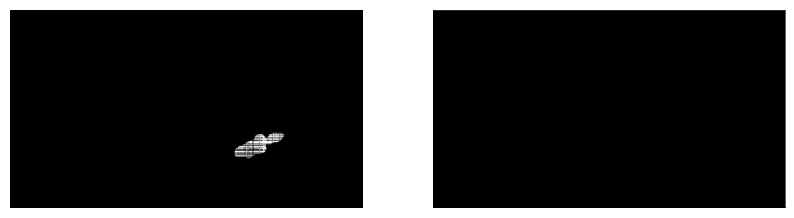

In [236]:
show(mask, out)

## Evaluation Functions

In [237]:
@torch.no_grad()
def evaluate(model, dl, metric_funcs={}):
    model.eval()
    metrics = {key: [] for key in metric_funcs}
    
    progress_bar = Progbar(len(dl))
    
    for i, (x, y) in enumerate(dl):
        pred = model(x)
        
        for key, func in metric_funcs.items():
            pred = pred.view(-1).type(torch.uint8)
            y = y.view(-1).type(torch.uint8)

            value = func(pred, y).item()
            
            if type(value) not in [float, int]:
                raise Exception("Metric function must return a integer or a float")

            metrics[key].append(value)
        
        progress_bar.update(i+1, [(key, value[-1]) for key, value in metrics.items()])

    return {key: np.mean(np.array(value)) for key, value in metrics.items()}

In [238]:
f1 = BinaryF1Score().to(device)
iou = BinaryJaccardIndex().to(device)
metrics = evaluate(ensemble_model, test_dl, {"F1": f1, "iou": iou})

50/50 [==============================] - 120s 2s/step - F1: 0.0012 - iou: 5.9896e-04


## F1

In [239]:
print("F1:", metrics["F1"])

F1: 0.0011963642952468945


## IOU

In [240]:
print("IOU:", metrics["iou"])

IOU: 0.0005989587074509472
